Mejores Hiperparámetros: {'alpha': 1.0, 'fit_prior': False}

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68     11204
           1       0.54      0.44      0.48     11181
           2       0.86      0.79      0.82     21474

    accuracy                           0.70     43859
   macro avg       0.66      0.67      0.66     43859
weighted avg       0.71      0.70      0.70     43859



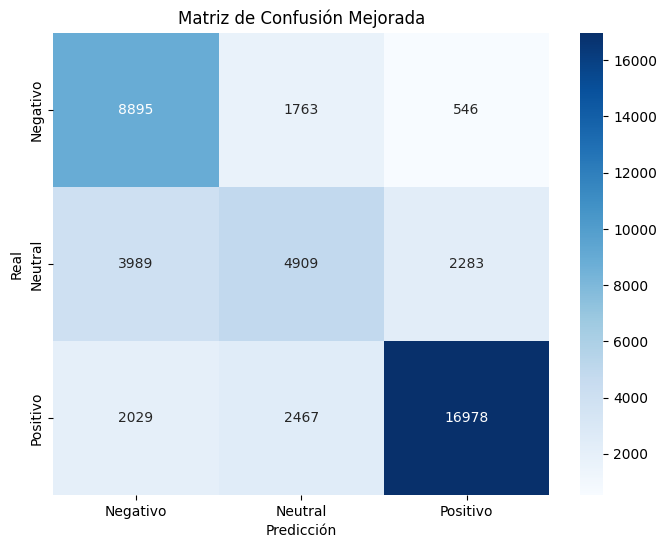

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Importar bibliotecas necesarias para el procesamiento de texto
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns

# Importar las bibliotecas necesarias desde TensorFlow para el modelo RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import Dropout

# Importar bibliotecas necesarias de Scikit-learn para dividir los datos
from sklearn.model_selection import train_test_split

# Importar bibliotecas necesarias para la manipulación de datos y vectores
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd


# Importar bibliotecas necesarias para trabajar con el modelo
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical


# Cargar el archivo CSV
data_path = '../data/Sentimiento.csv'
df = pd.read_csv(data_path)

# Preprocesamiento del texto
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Eliminar menciones y hashtags
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'\W', ' ', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text).strip()  # Eliminar espacios extra
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

df['texto_preprocesado'] = df['texto'].apply(preprocess_text)

# Paso 1: Retokenizar y preparar las secuencias
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(df['texto_preprocesado'])
secuencias = tokenizer.texts_to_sequences(df['texto_preprocesado'])
max_length = 50

# Vectorizar texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=70000)
X = vectorizer.fit_transform(df['texto_preprocesado'])

# Obtener las etiquetas
y = df['sentimiento'].values
class_mapping = {"good": 0, "neutral": 1, "bad": 2}
y_mapped = [class_mapping[label] for label in y]
y_one_hot = to_categorical(y_mapped, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Convertir las etiquetas one-hot a una representación unidimensional para Naive Bayes
y_train_nb = np.argmax(y_train, axis=1)
y_test_nb = np.argmax(y_test, axis=1)

# Ajustar Naive Bayes con GridSearchCV
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'fit_prior': [True, False]
}
grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train_nb)

# Obtener el mejor modelo y parámetros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Mejores Hiperparámetros: {best_params}")

# Evaluar el modelo optimizado
y_pred = best_model.predict(X_test)
classification_rep = classification_report(y_test_nb, y_pred)
confusion_mat = confusion_matrix(y_test_nb, y_pred)

print("\nReporte de Clasificación:")
print(classification_rep)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Neutral', 'Positivo'],
            yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.title('Matriz de Confusión Mejorada')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()
